In [50]:
# Import necessary modules for statistical analysis
import json
import numpy as np
import matplotlib as mpl
import matplotlib.font_manager
mpl.use('Agg')
params = {'font.family': 'serif','font.serif': 'Times', 'text.usetex': True,'mathtext.fontset': 'custom'}
mpl.rcParams.update(params)
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import gridspec

In [51]:
anno_file = '../data/swallow/anno/swallow_singlestage_without_all.json' # 8 classes

In [52]:
# mask_label_ids = [7, 14, 10, 9, 0, 8, 11]
mask_label_ids = []

In [53]:
# read json data from file
with open(anno_file) as f:
    data = json.load(f)
if 'database' in data.keys():
    data = data['database']

In [54]:
len(data)

845

In [55]:
# calculate the total number of frames for different subsets
train_total_frames = 0
val_total_frames = 0
test_total_frames = 0
for vid in data.keys():
    if data[vid]['subset'] == 'Train':
        train_total_frames += int(data[vid]['duration'])
    elif data[vid]['subset'] == 'Validation':
        val_total_frames += int(data[vid]['duration'])
    elif data[vid]['subset'] == 'Test':
        test_total_frames += int(data[vid]['duration'])
print('Total durations in training set: {}'.format(train_total_frames))
print('Total durations in validation set: {}'.format(val_total_frames))
print('Total durations in testing set: {}'.format(test_total_frames))

Total durations in training set: 21815
Total durations in validation set: 8249
Total durations in testing set: 6798


In [56]:
# Extract all action durations (segments) for statistical analysis
action_durations = []
video_idx = []
aggreated = {}

for video_key, video_value in data.items():
    annotations = video_value.get("annotations", [])
    if video_value['subset'] not in aggreated.keys():
        aggreated[video_value['subset']] = {
            'action_durations': [],
            'video_idx': [],
            'action_durations_unit': [],
            'action_start_unit': [],
        }
    video_duration = video_value.get("duration", 0)
    for annotation in annotations:
        # get label id 
        label_id = annotation.get("label_id", -1)
        if label_id in mask_label_ids:
            continue
        segment = annotation.get("segment", [])
        label = annotation.get("label", "Unknown")
        
        
        if len(segment) == 2:
            start, end = segment
            duration = end - start
            start_unit = start / video_duration * 100
            duration_unit = duration / video_duration * 100
            # assert start_unit >= 0 and start_unit < 1
            # assert duration_unit <= 1
            if duration < 0:
                print(f"Error: duration < 0, video_key:  {video_key}, segment: {segment}")
            aggreated[video_value['subset']]['action_durations'].append(round(duration,2))
            aggreated[video_value['subset']]['action_start_unit'].append(round(start_unit,8))
            aggreated[video_value['subset']]['action_durations_unit'].append(round(duration_unit,8))
            aggreated[video_value['subset']]['video_idx'].append(video_key)

In [57]:
keys = list(aggreated.keys())

In [58]:
keys

['Train', 'Validation', 'Test']

In [59]:
# action_durations = aggreated['validation']['action_durations']
action_durations = aggreated[keys[0]]['action_durations']

In [60]:
# Convert the list to a NumPy array for easier statistical analysis
action_durations = np.array(action_durations)

# Calculate statistical measures
mean_duration = np.mean(action_durations)
median_duration = np.median(action_durations)
min_duration = np.min(action_durations)
max_duration = np.max(action_durations)
std_deviation = np.std(action_durations)

In [61]:
len(action_durations)

4970

In [62]:
np.argmax(action_durations)

1087

In [63]:
np.ones_like(action_durations)[action_durations < 200].sum()

4970.0

In [64]:
np.ones_like(action_durations)[action_durations < 1].sum() / len(action_durations)

0.56841046277666

In [65]:
np.ones_like(action_durations)[action_durations < 2].sum() / len(action_durations)

0.9595573440643863

In [66]:
np.ones_like(action_durations)[action_durations < 0.5].sum() / len(action_durations)

0.16257545271629778

In [67]:
action_durations.argmin()

704

In [68]:
# Display statistical measures
mean_duration, median_duration, min_duration, max_duration, std_deviation

(0.9630040241448692, 0.9, 0.0, 3.14, 0.5356549705442074)

In [70]:
# # Plot a histogram to visualize the distribution of action durations
params = {
    'xtick.major.size': 3,
    'ytick.major.size': 3,
}
mpl.rcParams.update(params)
plt.figure(figsize=(8, 6))
plt.hist(action_durations, bins=20, alpha=1, color='#1F78B4', edgecolor=None,rwidth=0.9)
# plt.title("Distribution of Action Durations", fontsize=20)
# plt.grid(True, alpha=0.5)
plt.xlabel("Duration (seconds)", fontsize=18)
plt.ylabel("Instance Number", fontsize=18)
plt.axvline(mean_duration, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_duration:.2f} sec")
plt.axvline(median_duration, color='#D8E219', linestyle='dashed', linewidth=2, label=f"Median: {median_duration:.2f} sec")
plt.legend(fontsize=18)
plt.xlim(0, 3.5)
# axis label font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# axis line width
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.tight_layout()
plt.savefig('action_durations.png', dpi=600)
plt.close()


In [21]:
# Initialize a dictionary to store durations for each action category
action_category_durations = {}
action_category_start_n_duration_unit = {}
# Populate the dictionary
for video_key, video_value in data.items():
    if video_value['subset'] != 'Train':
        continue
    video_duration = video_value.get("duration", 0)
    annotations = video_value.get("annotations", [])
    for annotation in annotations:
        segment = annotation.get("segment", [])
        label = annotation.get("label", "Unknown")
        # get label id
        label_id = annotation.get("label_id", -1)
        if label_id in mask_label_ids:
            continue
        if len(segment) == 2:
            start, end = segment
            duration = end - start
            if label not in action_category_durations:
                action_category_durations[label] = []
                action_category_start_n_duration_unit[label] = []
            action_category_start_n_duration_unit[label]\
            .append((start/video_duration, duration/video_duration))
            action_category_durations[label].append(duration)

# Calculate statistical measures for each action category
action_category_stats = {}
for label, durations in action_category_durations.items():
    durations = np.array(durations)
    mean = np.mean(durations)
    median = np.median(durations)
    min_val = np.min(durations)
    max_val = np.max(durations)
    std_dev = np.std(durations)
    # round off the values to 2 decimal places
    mean = round(mean, 2)
    median = round(median, 2)
    min_val = round(min_val, 2)
    max_val = round(max_val, 2)
    std_dev = round(std_dev, 2)
    
    action_category_stats[label] = {
        "mean": mean,
        "median": median,
        "min": min_val,
        "max": max_val,
        "std_dev": std_dev
    }

In [22]:
# display the segment number of action categories
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(action_category_durations)), [len(durations) for durations in action_category_durations.values()])
# # add actual number on top of each bar
# for i, v in enumerate([len(durations) for durations in action_category_durations.values()]):
#     plt.text(i - 0.25, v + 10, str(v))
# plt.title("Number of Segments for Each Action Category")
# plt.xlabel("Action Category")
# plt.ylabel("Number of Segments")
# plt.xticks(range(len(action_category_durations)), list(action_category_durations.keys()), rotation=90)
# # show the plot
# plt.show()
# plt.close()

In [23]:
# # Display statistical measures for each action category
action_category_stats
# Plot a histogram to visualize the distribution of action durations for each action category
for label, durations in action_category_durations.items():
    durations = np.array(durations)
    mean = np.mean(durations)
    median = np.median(durations)
    min_val = np.min(durations)
    max_val = np.max(durations)
    std_dev = np.std(durations)
    
    plt.figure(figsize=(5, 4))
    plt.hist(durations, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Frequency")
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f"Mean: {mean:.2f} sec")
    plt.axvline(median, color='green', linestyle='dashed', linewidth=1, label=f"Median: {median:.2f} sec")
    # add total number of samples in the title
    plt.title(f"Distribution of Action Durations for {label} (n={len(durations)})")
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
# # Plot a histogram to visualize the distribution of action start and durations using heatmap
import scipy.ndimage.filters as filters
plt.figure(figsize=(5, 4))
plt.hist2d(aggreated[keys[0]]['action_start_unit'], aggreated[keys[0]]['action_durations'], bins=50, norm="linear")
# plt.title("Distribution of Action Start and Durations",fontsize=20)
# plt.xlabel("$\\frac{\\textrm{Start of Action}} {\\textrm{Video durtion}}$ (\%)", fontsize=12)
plt.xlabel("Start of Micro-Action / Video Duration(\%)",fontsize=12)
plt.ylabel("Action Duration (s)", fontsize=12)
# color bar with integer ticks
# limit x and y axis to 0-1
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar = plt.colorbar()
cbar.ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # 设置刻度为整数
# plt.grid(True)
plt.tight_layout()
plt.savefig('action_start_duration.png', dpi=600)
plt.close()

In [73]:
# 创建图形容器
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 1], wspace=0.08)  # 调整子图间距

# ===== 左图：水平直方图 =====
ax1 = fig.add_subplot(gs[0])
ax1.hist(action_durations, bins=20, alpha=1, color='#1F78B4',
         edgecolor=None, rwidth=0.9, orientation='horizontal')

ax1.yaxis.tick_right()

# 轴标签配置
ax1.set_xlabel("Count", fontsize=14, labelpad=5)
ax1.set_ylabel("Duration (seconds)", fontsize=14)

# 统计参考线
ax1.axhline(mean_duration, color='#70CF56', linestyle='dashed', linewidth=1.5,
            label=f"Mean: {mean_duration:.2f} sec")
ax1.axhline(median_duration, color='orange', linestyle='dashed', linewidth=1.5,
            label=f"Median: {median_duration:.2f} sec")

# ===== 右图：2D直方图 =====
ax2 = fig.add_subplot(gs[1], sharey=ax1)
hist = ax2.hist2d(
    aggreated[keys[0]]['action_start_unit'],
    aggreated[keys[0]]['action_durations'],
    bins=[50, 50],  # x轴50个bin，y轴20个bin（与左图对齐）
    range=[[0, 100], [0, 3.5]],  # 强制限定数据范围
    norm="linear",
    cmap='viridis'
)

# 隐藏重复的y轴刻度
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.spines['left'].set_visible(False)

# ===== 统一配置 =====
# 设置共同y轴范围
for ax in [ax1, ax2]:
    ax.set_ylim(0, 3.5)
    ax.tick_params(axis='both', which='major', labelsize=12)
    for spine in ax.spines.values():
        spine.set_linewidth(1)

# 颜色条配置
cbar = fig.colorbar(hist[3], ax=ax2, aspect=40, pad=0.01)
cbar.set_label('Instance Number', fontsize=14)
cbar.ax.tick_params(labelsize=10)

# 图例位置优化
ax1.legend(fontsize=12, loc='upper left', 
           frameon=False)
ax1.invert_xaxis()

# 标签对齐
ax2.set_xlabel("Start Time / Video Duration (\%)", fontsize=14, labelpad=5)
# ax2.xaxis.set_label_coords(0.5, -0.15)  # 调整x轴标签位置

plt.savefig('combined_plot_v2.png', dpi=600, bbox_inches='tight')
plt.close()

In [29]:
# action_category_durations.keys()

In [30]:
# plot the PDFof the start times of each action across all videos. 
# The start time is already normalized by the duration of the video.
# plt.figure(figsize=(5, 4))
# plt.hist(aggreated[keys[0]]['action_start_unit'], bins=50, alpha=0.7, color='blue', edgecolor='black')
# plt.title("Distribution of Action Start")
# plt.xlabel("Action Start")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()

In [31]:
# len(action_category_durations.keys())

In [32]:
# examine whether there is overlap between actions in the same video
# exam through every video
for video_key, video_value in tqdm(data.items()):
    annotations = video_value.get("annotations", [])
    # get segment for each action
    segments = []
    # get label
    for annotation in annotations:
        segment = annotation.get("segment(frames)", [])
        segments.append((segment[0], segment[1], annotation.get("label", "Unknown")))
    

    # sort the segments by start time
    segments.sort(key=lambda x: x[0])
    # check if there is overlap between actions
    for i in range(len(segments) - 1):
        if segments[i][1] > segments[i+1][0]:
            print(f"Overlap detected in video {video_key}: '{segments[i][-1]}':{segments[i][:-1]} and '{segments[i+1][-1]}': {segments[i+1][:-1]}")

100%|██████████| 169/169 [00:00<00:00, 35030.26it/s]

Overlap detected in video 16: 'direct_gonioscopy':(9450, 14491) and 'Goniotomy': (11514, 14400)
Overlap detected in video 17: 'direct_gonioscopy':(15925, 21912) and 'Goniotomy': (19417, 21189)
Overlap detected in video 19: 'direct_gonioscopy':(21446, 24435) and 'Goniotomy': (21929, 24413)
Overlap detected in video 24: 'direct_gonioscopy':(6304, 12353) and 'Goniotomy': (8756, 12212)
Overlap detected in video 24: 'direct_gonioscopy':(21450, 23583) and 'Goniotomy': (22639, 23488)
Overlap detected in video 26: 'direct_gonioscopy':(4012, 7511) and 'Goniotomy': (5300, 7160)
Overlap detected in video 27: 'direct_gonioscopy':(4362, 8720) and 'Goniotomy': (7235, 7912)
Overlap detected in video 29: 'direct_gonioscopy':(3702, 7258) and 'Goniotomy': (4215, 6616)
Overlap detected in video 31: 'direct_gonioscopy':(3773, 7127) and 'Goniotomy': (4962, 6606)
Overlap detected in video 33: 'direct_gonioscopy':(4970, 8745) and 'Goniotomy': (6137, 7741)
Overlap detected in video 33: 'direct_gonioscopy':(97

## Video level info analysis

In [33]:
data

{'16': {'annotations': [{'segment(frames)': [2862, 3311],
    'label': 'corneal_incision 30 degree',
    'label_id': 6,
    'segment': [114.5, 132.4]},
   {'segment(frames)': [3414, 3762],
    'label': 'carbachol_injection',
    'label_id': 0,
    'segment': [136.6, 150.5]},
   {'segment(frames)': [3986, 5465],
    'label': 'CVA_injection',
    'label_id': 1,
    'segment': [159.4, 218.6]},
   {'segment(frames)': [9450, 14491],
    'label': 'direct_gonioscopy',
    'label_id': 2,
    'segment': [378.0, 579.7]},
   {'segment(frames)': [11514, 14400],
    'label': 'Goniotomy',
    'label_id': 3,
    'segment': [460.6, 576.0]},
   {'segment(frames)': [19925, 23583],
    'label': 'CVA_irrigation/aspiration',
    'label_id': 4,
    'segment': [797.0, 943.3]},
   {'segment(frames)': [23658, 24331],
    'label': 'suture',
    'label_id': 5,
    'segment': [946.3, 973.3]}],
  'video_id': 16,
  'org': 'ZOC',
  'concrete org': 'ZOC',
  'clear': True,
  'operation type': 'GT120',
  'knife': 'TMH'

In [34]:
# analyze the [average frames per video; total frames; idle frames] grouped by subset
# initialize a dictionary to store the statistics
subset_stats = {}
# populate the dictionary
for video_key, video_value in data.items():
    subset = video_value.get("subset", "Unknown")
    n_frames = video_value.get("frame_count", 0)
    activity_frames = 0
    for action in video_value.get("annotations", []):
        activity_frames += action.get("segment(frames)", [0, 0])[1] - action.get("segment(frames)", [0, 0])[0]
    idle_frames = n_frames - activity_frames
    if subset not in subset_stats:
        subset_stats[subset] = {
            "n_videos": 0,
            "n_frames": 0,
            'n_idle_frame':0,
            "avg_n_frames": 0,
        }
    subset_stats[subset]["n_videos"] += 1
    subset_stats[subset]["n_frames"] += n_frames
    subset_stats[subset]["n_idle_frame"] += idle_frames

# calculate the average number of frames per video
for subset, stats in subset_stats.items():
    stats["avg_n_frames"] = stats["n_frames"] / stats["n_videos"]


In [35]:
subset_stats

{'validation': {'n_videos': 36,
  'n_frames': 1052235,
  'n_idle_frame': 207755,
  'avg_n_frames': 29228.75},
 'training': {'n_videos': 101,
  'n_frames': 2961748,
  'n_idle_frame': 1253314,
  'avg_n_frames': 29324.237623762376},
 'testing': {'n_videos': 32,
  'n_frames': 935198,
  'n_idle_frame': 409371,
  'avg_n_frames': 29224.9375}}

In [36]:
import pandas as pd
# convert the dictionary to a pandas DataFrame for easier visualization
df = pd.DataFrame(subset_stats)
df
df.to_csv('total&idle_stats.csv')

## Draw Violin plot

In [44]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# Initialize empty lists to hold data
video_names = []
start_frames = []
end_frames = []
action_names = []
action_durs = []
subsets = []
orgs = []
action_range = []
video_frames = []

# Loop through the data to populate the lists
for video_name, video_data in data.items():
    annotations = video_data['annotations']
    subset = video_data['subset'].replace('Train', 'Train Set').replace('Validation', 'Validation Set').replace('Test', 'Test Set')
    frame_count = int(video_data['fps'] * video_data['duration'])
    # org = video_data['org']
    for annotation in annotations:
        segment = annotation['segment(frames)']
        label = annotation['label'].replace('_', ' ')
        # Populate the lists
        video_names.append(video_name)
        start_frames.append(segment[0])
        end_frames.append(segment[1])
        action_frames = segment[1] - segment[0]
        action_durs.append(action_frames)
        action_names.append(label)
        subsets.append(subset)
        # orgs.append(org)
        action_range.append(list(range(segment[0], segment[1]+1)))
        video_frames.append(frame_count)

# Create a DataFrame
df = pd.DataFrame({
    'video_name': video_names,
    'start_frame': start_frames,
    'end_frame': end_frames,
    'action_name': action_names,
    'subset': subsets,
    'action_duration_frames': action_durs,
    # 'org': orgs,
    'action_range': action_range,
    'video_frames': video_frames
})

# Show the first few rows of the DataFrame
df.head()

,video_name,start_frame,end_frame,action_name,subset,action_duration_frames,action_range,video_frames
0,1_24_869782_wang2xiao3zhu2_zheng4chang2lao3nia...,814,849,OralDelivery,Train Set,35,"[814, 815, 816, 817, 818, 819, 820, 821, 822, ...",958
1,1_24_869782_wang2xiao3zhu2_zheng4chang2lao3nia...,819,873,SoftPalateLift,Train Set,54,"[819, 820, 821, 822, 823, 824, 825, 826, 827, ...",958
2,1_24_869782_wang2xiao3zhu2_zheng4chang2lao3nia...,847,892,HyoidExercise,Train Set,45,"[847, 848, 849, 850, 851, 852, 853, 854, 855, ...",958
3,1_24_869782_wang2xiao3zhu2_zheng4chang2lao3nia...,853,876,UESOpen,Train Set,23,"[853, 854, 855, 856, 857, 858, 859, 860, 861, ...",958
4,1_24_869782_wang2xiao3zhu2_zheng4chang2lao3nia...,847,849,ThroatSwallow,Train Set,2,"[847, 848, 849]",958


In [34]:
len(df)

8085

In [45]:
# sum the action_duration_frames for each action_name
action_durations = df.groupby(['subset','action_name'])['action_duration_frames'].sum()
# convert the Series to a DataFrame
action_durations = action_durations.to_frame()
action_durations

action_duration_frames
subset         action_name                                      
Test Set       HyoidExercise                               13163
               LaryngealVestibuleClosure                    3123
               OralDelivery                                 5048
               SoftPalateLift                               6010
               ThroatSwallow                                2582
               ThroatTransport                              7703
               UESOpen                                      3966
Train Set      HyoidExercise                               31521
               LaryngealVestibuleClosure                   17197
               OralDelivery                                18076
               SoftPalateLift                              28449
               ThroatSwallow                                6425
               ThroatTransport                             26267
               UESOpen                                     15605
Validation Set HyoidExercise                               11920
               LaryngealVestibuleClosure                    5660
               OralDelivery                                 6224
               SoftPalateLift                              10588
               ThroatSwallow                                2385
               ThroatTransport                             10926
               UESOpen                                      6887

In [46]:
new_subsets = []
actions = []
# loop every row in the dataframe
for idx, action in enumerate(action_range):
    if len(new_subsets) == 0:
        new_subsets = [subsets[idx]]*len(action)
        new_action_names = [action_names[idx]]*len(action)
        new_actions = action
        new_video_names = [video_names[idx]]*len(action)
        new_actions_ratio = [i/video_frames[idx] for i in action]
    else:
        # extends the list
        new_subsets.extend([subsets[idx]]*len(action))
        new_action_names.extend([action_names[idx].replace("_"," ")]*len(action))
        new_actions.extend(action)
        new_video_names.extend([video_names[idx]]*len(action))
        new_actions_ratio.extend([i/video_frames[idx]*100 for i in action])

# create a new dataframe
new_df = pd.DataFrame({
    'subset': new_subsets,
    'action_name': new_action_names, 
    'action_by_frame': new_actions, 
    'video_name': new_video_names,
    'action_by_ratio': new_actions_ratio,
})

In [42]:
# new_name_replace = [
#     "Corneal incision by 15 degree keratome",
#     "Corneal incision by 3.2 mm keratome",
#     "Carbachol injection",
#     "OVDs injection",
#     "Gonioscopy",
#     "Goniotomy",
#     "OVDs irrigation/aspiration",
#     "Would closure"
# ]

# old = [
#     'corneal incision 15 degree',
#     'corneal incision 30 degree',
#     'carbachol injection',
#     'CVA injection',
#     'direct gonioscopy',
#     'Goniotomy',
#     'CVA irrigation/aspiration',
#     'suture'
# ]

# for idx, name in enumerate(new_name_replace):
#     new_df['action_name'] = new_df['action_name'].replace(old[idx], name)

In [47]:
new_df.sort_values(by=['action_name'], inplace=True)

In [48]:
new_df

,subset,action_name,action_by_frame,video_name,action_by_ratio
123904,Train Set,HyoidExercise,1595,7_112_2020102702_yang2miao4zhen12_cha2ti3_2020...,83.289817
143791,Train Set,HyoidExercise,946,4_64_2020092302_liu2jin1zhen1_cha2ti3_2020_09_...,49.399478
143790,Train Set,HyoidExercise,945,4_64_2020092302_liu2jin1zhen1_cha2ti3_2020_09_...,49.347258
143789,Train Set,HyoidExercise,944,4_64_2020092302_liu2jin1zhen1_cha2ti3_2020_09_...,49.295039
143788,Train Set,HyoidExercise,943,4_64_2020092302_liu2jin1zhen1_cha2ti3_2020_09_...,49.242820
...,...,...,...,...,...
113345,Validation Set,UESOpen,208,9_128_2020101202_li3ning2_cha2ti3_2020_10_13_1...,10.861619
113346,Validation Set,UESOpen,209,9_128_2020101202_li3ning2_cha2ti3_2020_10_13_1...,10.913838
113347,Validation Set,UESOpen,210,9_128_2020101202_li3ning2_cha2ti3_2020_10_13_1...,10.966057
113336,Validation Set,UESOpen,199,9_128_2020101202_li3ning2_cha2ti3_2020_10_13_1...,10.391645


In [36]:
sns.color_palette("Set2").as_hex()[1]

'#fc8d62'

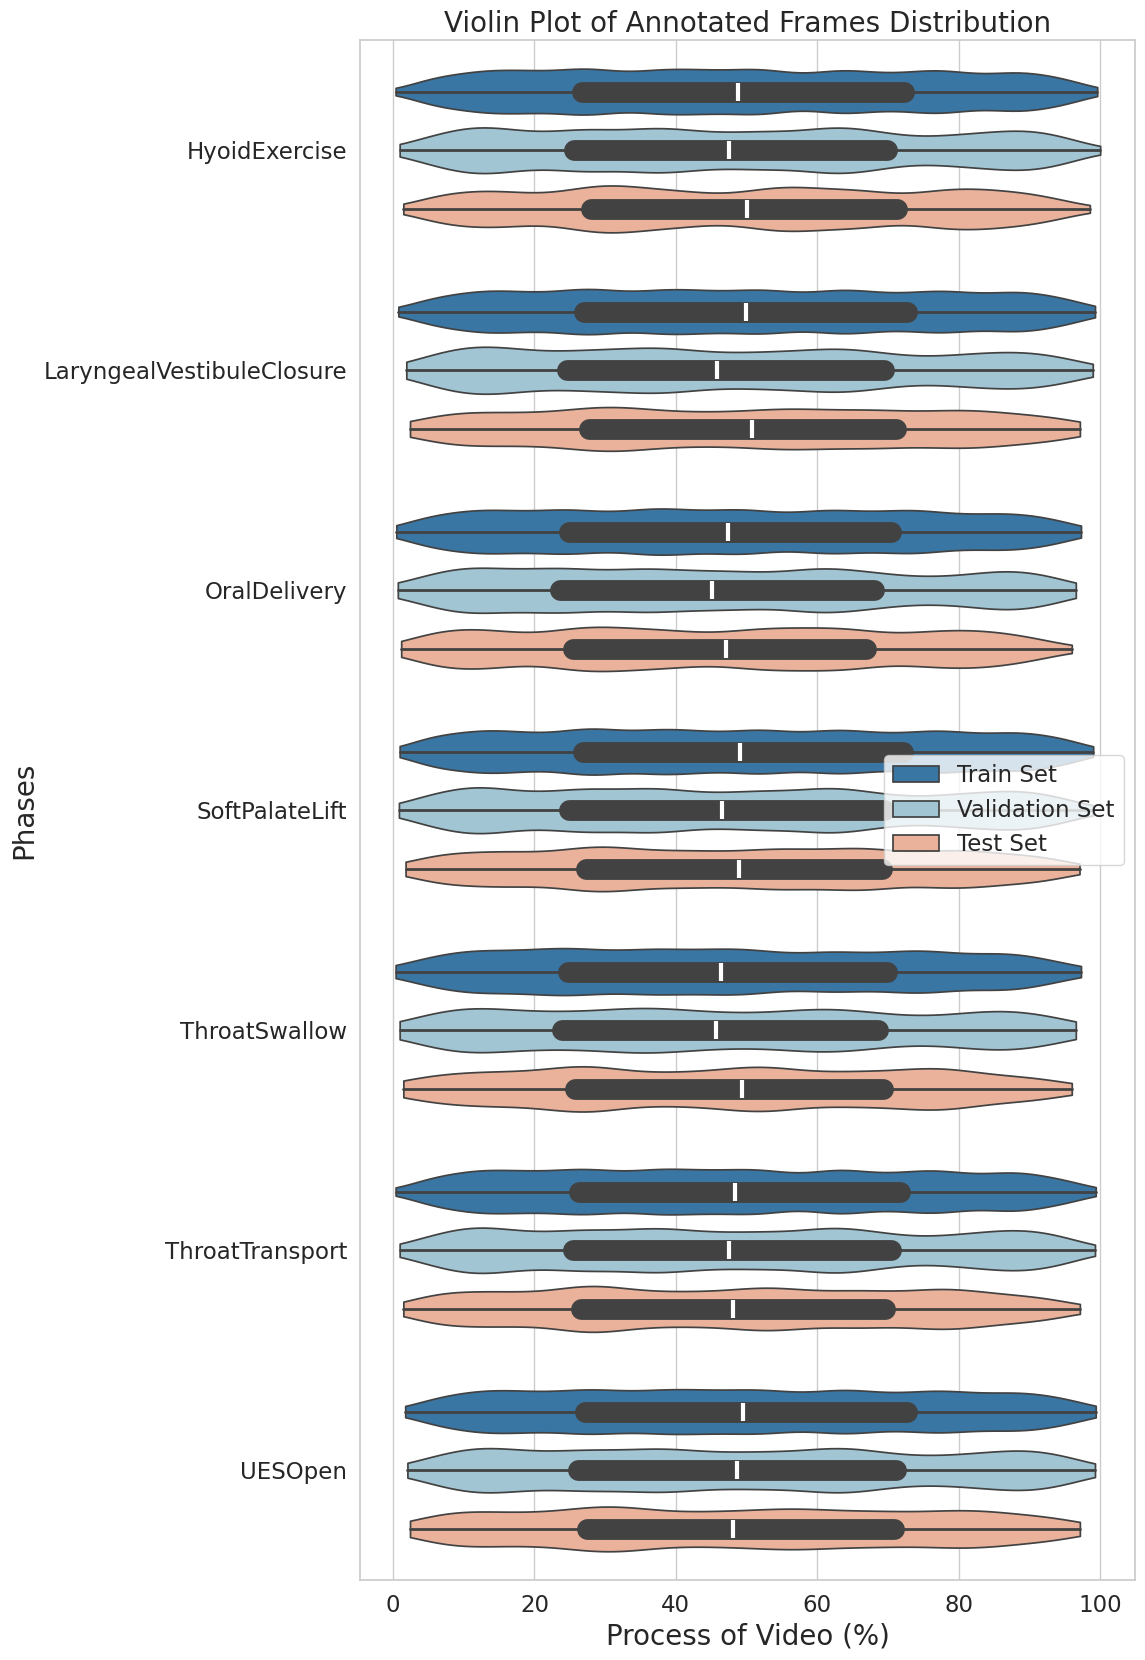

In [50]:
# set font family
plt.rcParams.update({'font.family':'Arial', 'font.size': 20})
plt.figure(figsize=(10, 20))
# initialize a seaborn barplot
# sns.set_theme(palette=['#2878B5','#962028','#CF8404'],style="whitegrid")
# sns.set_theme(palette=['#FF8884','#C82423','#F8AC8C'],style="whitegrid") # RED
sns.set_theme(palette=['#2878B5','#9AC9DB','#F8AC8C'],style="whitegrid",font_scale=1.5) # dark blue, light blue, orange
sns.violinplot(y='action_name', x='action_by_ratio', 
            # order=new_name_replace,
            hue='subset', 
            hue_order = ['Train Set', 'Validation Set', 'Test Set'],
            data=new_df, split=False, cut=0,
            gap=0.2,
            inner_kws=dict(box_width=15, whis_width=2))
# Add titles and labels
plt.title('Violin Plot of Annotated Frames Distribution',fontsize=20)
plt.xlabel('Process of Video (%)',fontsize=20)
plt.ylabel('Phases',fontsize=20)

# # Add a legend
plt.legend(title='')

# Rotate x labels for better visibility
# plt.xticks(rotation=30)

# Show the plot
plt.show()

## !交错的片段可能无法表示

短约11000帧：26 或144
中约20000帧：47或90
长约33000帧：19或276

In [ ]:
# transform annotation to numpy array
# Select three example videos
example_video_names = ['26','47','154']
# initialize a list to hold the annotations
example_annotations = []
# loop through the data
for i, video_name in enumerate(example_video_names):
    # get len
    video_len = data[video_name]['frame_count']
    video_array = np.zeros(video_len)
    # get the annotations for the video
    annotations = data[video_name]['annotations']
    # loop through the annotations
    for annotation in annotations:
        # get the segment
        segment = annotation['segment(frames)']
        # get the label id
        label_id = annotation['label_id'] + 1 
        # map the array
        video_array[segment[0]:segment[1]+1] = label_id
    # append the array to the list
    example_annotations.append(video_array)

In [ ]:
example_video_names

['26', '47', '154']

In [ ]:
# # extend the array to 2d (L) -> (30,L)
# width = 2000
# def expand(array):
#     return np.expand_dims(array, axis=0).repeat(width, axis=0)
# a,b,c = map(expand,example_annotations)
# example_annotations_arr = [a,b,c]
# # extract idle frame index frame array
# a,b,c = map(lambda x: np.where(x==0)[1], example_annotations_arr)

In [ ]:
def idle_frames(arr):
    zero_indices = np.where(arr == 0)[0]

    # 找出值为0的元素的连续段
    consec_zeros = np.split(zero_indices, np.where(np.diff(zero_indices) != 1)[0]+1)

    # 找出每个连续段的起始和结束索引
    start_indices = [segment[0] for segment in consec_zeros]
    end_indices = [segment[-1] + 1 for segment in consec_zeros]
    return start_indices, end_indices

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.


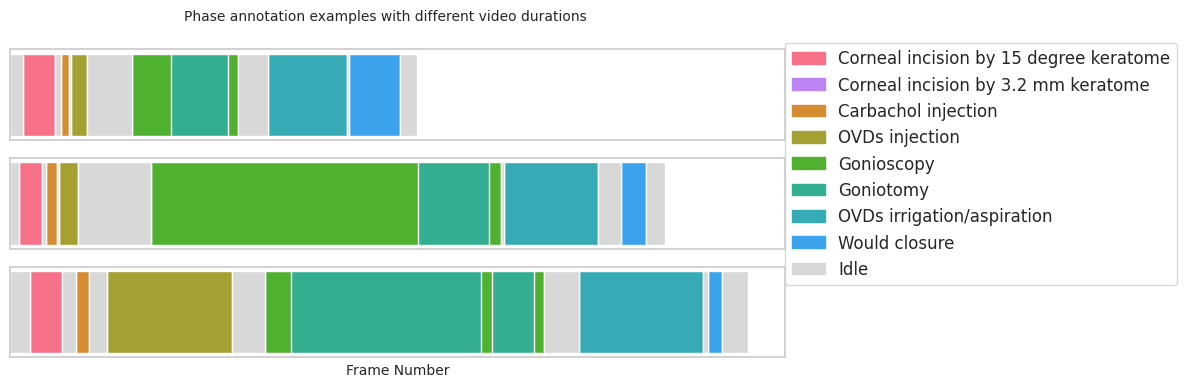

In [ ]:
example_video_names = ['26','47','154']

# Define a color map to use consistent colors for the same action categories
unique_actions = df['action_name'].unique()
unique_actions = unique_actions.tolist()
unique_actions.append("Idle")
unique_actions = np.array(unique_actions)

# replace the action name
replace_dict = {k:v for k,v in zip(old, new_name_replace)}
unique_actions_new = [replace_dict[i] for i in unique_actions[:-1]]
unique_actions_new.append('Idle')

# set the color map
color_list = sns.color_palette("husl", 9)
color_map = {action: color_list[i] for i, action in enumerate(unique_actions)}
idle_color = (0.84765625,0.84765625,0.84765625)
color_map['Idle'] = idle_color

new_name_replace.append('Idle')
# Initialize plotting
fig, axs = plt.subplots(len(example_video_names), 1, figsize=(10, 4),sharex=True)
fig.suptitle('Phase annotation examples with different video durations', fontsize=10)
custom_params = {"axes.spines.right": False, "axes.spines.top": False,"axes.spines.left": False, "axes.spines.bottom": False}
sns.set_theme(style="ticks", rc=custom_params)

# Create a custom legend to map colors to action categories
legend_patches = [plt.Rectangle((0,0),1,1, color=color_map[action]) for action in unique_actions]
# swap the legend order: move the last second to the second and remain the others
legend_patches = [legend_patches[0], legend_patches[-2], *legend_patches[1:-2], legend_patches[-1]] 
# LOC: (x, y) x: 0 is left, 1 is right; y: 0 is bottom, 1 is top
plt.legend(legend_patches, new_name_replace, loc=(1, 0.8), prop={'size': 12})

# Plotting stacked bar for each example video
for i, video_name in enumerate(example_video_names):
    video_data = df[df['video_name'] == video_name].sort_values('start_frame')
    starts = video_data['start_frame']
    durations = video_data['end_frame'] - video_data['start_frame']
    colors = [color_map[action] for action in video_data['action_name']]
    
    # Plotting
    axs[i].barh(y=0, width=durations,height=0.2, left=starts, color=colors)
    # axs[i].set_title(f'Video: {video_name}')
    axs[i].set_xlabel('')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# draw idle frames
# 1. calculate the idle frames
for i, example in enumerate(example_annotations):
    start_indices, end_indices = idle_frames(example)
    for j in range(len(start_indices)):
        axs[i].barh(y=0, width=end_indices[j]-start_indices[j],height=0.2, left=start_indices[j], color=idle_color)

fig.subplots_adjust(wspace=0.1)

plt.ylabel('')
plt.xlabel('Frame Number', fontsize=10)
plt.rcParams.update({'font.size': 14})
# Show plot
# plt.tight_layout(rect=[0, 0, 1, 1])  # To make space for the suptitle
plt.show()


Conclusion: 
- Some labels are extremely rare (electrocautery, corneal_incision, Sature, SPI)

Augmentation:
- Random rotation (allow upside down)
- Random crop (drop clips does not contain complete action)